In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.segment import datasets
import livecell_tracker.segment
from livecell_tracker import segment
import livecell_tracker.core.utils
from tqdm import tqdm
seg_path = r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched"""
label_seg_imgs = segment.datasets.LiveCellImageDataset(seg_path, ext="png")
dir_path = Path(
    r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
raw_imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="png")

288 png img file paths loaded: 
288 png img file paths loaded: 


In [2]:
def gen_detections_for_sort_tracker(label_mask):
    """
        generate detections for SORT tracker. detections: [x1, y1, x2, y2, score]
    Parameters
    ----------
    label_mask :
        an image
    Returns
    -------
    A list of (x1, y1, x2, y2, score]) for each object detected
    """    
    regionprops_skimge = measure.regionprops(label_mask)
    boxes = livecell_tracker.core.utils.get_bbox_from_regionprops(regionprops_skimge)
    detections = np.array([list(bbox) + [1] for bbox in boxes])
    return detections

import livecell_tracker.track.sort_tracker
MAX_AGE=5
MIN_HITS=1
tracker = livecell_tracker.track.sort_tracker.Sort(max_age=MAX_AGE, min_hits=MIN_HITS)

all_track_bbs = []
for i, img in enumerate(tqdm(label_seg_imgs)):
    detections = gen_detections_for_sort_tracker(img)
    track_bbs_ids = tracker.update(detections)
    all_track_bbs.append(track_bbs_ids)
    # for testing
    # if i > 5:
    #     break

100%|██████████| 288/288 [00:12<00:00, 23.14it/s]


In [3]:
all_track_bbs[0].shape

(27, 5)

convert to int

In [4]:
all_track_bbs = [track_bbs.astype(np.int32).tolist() for track_bbs in all_track_bbs]
all_track_bbs[0]

[[1, 1396, 67, 1581, 27],
 [734, 2114, 914, 2264, 26],
 [382, 274, 469, 390, 25],
 [1385, 1310, 1445, 1363, 24],
 [1395, 1278, 1450, 1323, 23],
 [1829, 1590, 1906, 1619, 22],
 [144, 1333, 231, 1391, 21],
 [285, 270, 342, 358, 20],
 [60, 1266, 148, 1329, 19],
 [90, 1414, 166, 1473, 18],
 [1850, 1369, 1904, 1419, 17],
 [12, 1234, 301, 1400, 16],
 [271, 465, 351, 529, 15],
 [7, 1234, 115, 1304, 14],
 [760, 2236, 987, 2377, 13],
 [1012, 2321, 1102, 2385, 12],
 [103, 1304, 322, 1406, 11],
 [1733, 1571, 1989, 1690, 10],
 [988, 2282, 1140, 2402, 9],
 [780, 2238, 821, 2253, 8],
 [1783, 1494, 2034, 1574, 7],
 [69, 424, 607, 694, 6],
 [350, 180, 584, 413, 5],
 [1789, 1256, 2015, 1480, 4],
 [48, 1391, 280, 1543, 3],
 [1297, 1159, 1571, 1481, 2],
 [152, 190, 359, 445, 1]]

### Save track bbox results to json for later development

In [5]:
dest_track_bbs_path = "detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json"
import json
with open(dest_track_bbs_path, "w+") as out_f:
    json.dump(all_track_bbs, out_f)


## Visualize Track results

In [6]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.segment import datasets
import livecell_tracker.segment
from livecell_tracker import segment
import livecell_tracker.core.utils
from tqdm import tqdm
seg_path = r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched"""
label_seg_imgs = segment.datasets.LiveCellImageDataset(seg_path, ext="png")
dir_path = Path(
    r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
raw_imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="png")

288 png img file paths loaded: 
288 png img file paths loaded: 


### load bbox paths

In [7]:
import json
MAX_AGE, MIN_HITS = 1, 1
_track_bbs_path = "../cxa-data/test_data/sort_track/max_age-{}_min_hit-{}_detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json".format(MAX_AGE, MIN_HITS)
print("loading: ", _track_bbs_path)
with open(_track_bbs_path, "r") as in_f:
    json_in = json.load(in_f)
type(json_in[0][0][0])

loading:  ../cxa-data/test_data/sort_track/max_age-1_min_hit-1_detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json


int

In [8]:
all_track_bbs = [np.array(track_bbs, dtype=int) for track_bbs in json_in]

In [9]:
all_track_bbs[0].shape

(27, 5)

### Manually check bboxes  
 - be careful: coordinates of numpy/skimage/cv2/pixel/rowCol/bbox

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
idx = 2
bboxes = all_track_bbs[idx]
fig, ax = plt.subplots()
ax.imshow(raw_imgs[idx])
for bbox in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[1], bbox[0]),  (bbox[3] - bbox[1]), (bbox[2] - bbox[0]), linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
# plt.show()


In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic, single_cell

id_to_sc_trajs = {}
for timeframe, objects in enumerate(all_track_bbs):
    for obj in objects:
        track_id = obj[-1]
        if not (track_id in id_to_sc_trajs):
            new_traj = SingleCellTrajectory(raw_imgs, track_id=track_id)
            id_to_sc_trajs[track_id] = new_traj
        # print("obj: ", obj)
        sc = SingleCellStatic(
            timeframe, bbox=obj[:4], img_dataset=raw_imgs
        )  # final column is track_id, ignore as we only need bbox here
        _traj = id_to_sc_trajs[track_id]
        _traj.add_timeframe_data(timeframe, sc)


### length distribution

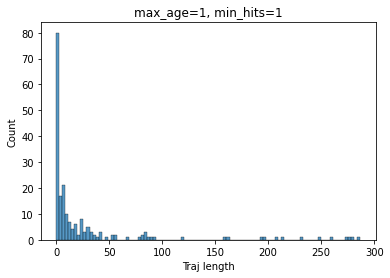

In [12]:
%matplotlib inline
import seaborn as sns
all_traj_lengths = np.array([_traj.get_timeframe_span_length() for _traj in id_to_sc_trajs.values()])
sns.histplot(all_traj_lengths, bins=100)
plt.title("max_age={}, min_hits={}".format(MAX_AGE, MIN_HITS))
plt.ylabel("Count")
plt.xlabel("Traj length")
plt.show()

In [13]:
(all_traj_lengths > 10).sum(), (all_traj_lengths > 30).sum(), (all_traj_lengths > 50).sum()

(77, 39, 28)